## <p style="background-color:#709699;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">Information sur le dataset</p>

Le but de cette analyse est de fournir une méthode d'identification précoce des élèves à risque d'échec. Ceci est vital pour toutes les plateformes d'apprentissage, en particulier celles en ligne. Les données utilisées sont le jeu de données Open University Learning Analytics (OULAD).

Pour les information detaillé <a href="https://analyse.kmi.open.ac.uk/open_dataset#about">data info</a>

## <p style="background-color:#709699;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">IMPORTATION DES PACKAGES</p>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Chargement 

In [2]:
csv_path = 'anonymisedData/'
data_dicts = {csv_name[:-4]: pd.read_csv(csv_path+csv_name) for csv_name in os.listdir(csv_path)}

## <p style="background-color:#709699;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">EXPLORATION DES DONNEES</p>

### courses.csv

In [3]:
data_dicts['courses'].groupby(['code_module','code_presentation']).agg(['min','max'])

module_presentation_length     
                                                     min  max
code_module code_presentation                                
AAA         2013J                                    268  268
            2014J                                    269  269
BBB         2013B                                    240  240
            2013J                                    268  268
            2014B                                    234  234
            2014J                                    262  262
CCC         2014B                                    241  241
            2014J                                    269  269
DDD         2013B                                    240  240
            2013J                                    261  261
            2014B                                    241  241
            2014J                                    262  262
EEE         2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
FFF         2013B                                    240  240
            2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
GGG         2013J                                    261  261
            2014B                                    241  241
            2014J                                    269  269

Selon la documentation des données, il y a 8 cours (modules) enregistrés, de A à G (AAA dans dataset, désormais abrégé en A). Il y a 2 semestres enregistrés, février (B) et octobre (J). Les semestres de février sont généralement 20 jours plus courts que ceux d'octobre. Certains cours (C,E,G) n'ont pas de données pour 2013 et 2014.

### assessments.csv

In [4]:
df = data_dicts['assessments']
df.drop(['date','weight'],axis = 1).groupby(['code_module','assessment_type','code_presentation']).count()

id_assessment
code_module assessment_type code_presentation               
AAA         Exam            2013J                          1
                            2014J                          1
            TMA             2013J                          5
                            2014J                          5
BBB         CMA             2013B                          5
                            2013J                          5
                            2014B                          5
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          5
CCC         CMA             2014B                          4
                            2014J                          4
            Exam            2014B                          2
                            2014J                          2
            TMA             2014B                          4
                            2014J                          4
DDD         CMA             2013B                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          6
EEE         Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          4
                            2014B                          4
                            2014J                          4
FFF         CMA             2013B                          7
                            2013J                          7
                            2014B                          7
                            2014J                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          5
                            2013J                          5
                            2014B                          5
                            2014J                          5
GGG         CMA             2013J                          6
                            2014B                          6
                            2014J                          6
            Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          3
                            2014B                          3
                            2014J                          3

Le cours C comporte 2 examens finaux. Le cours A n'a pas d'évaluation par ordinateur (CMA). Chaque cours a au moins 3 TMA.

## vle.csv

In [5]:
df = data_dicts['vle']
df.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


## studentInfo.csv

In [6]:
df = data_dicts['studentInfo']
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [7]:
print("Le nombres de valeur manquante par colonne  ")
df.isnull().sum()

Le nombres de valeur manquante par colonne  


code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

Il y a 1111 observations avec imd_band (Index of Multiple Depravation, un index pour les conditions de vie) manquantes. Un élément que nous pourrions vouloir prendre en compte lors de la construction du modèle plus tard.

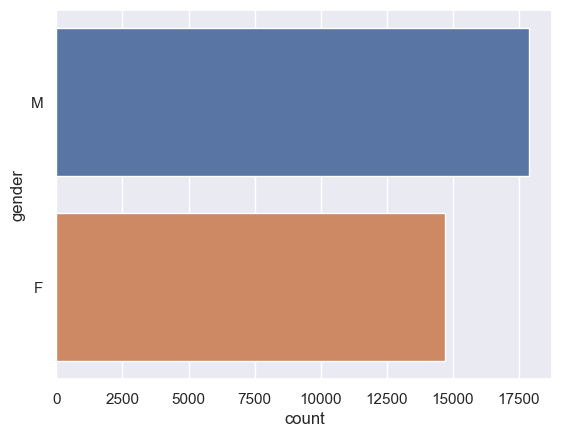

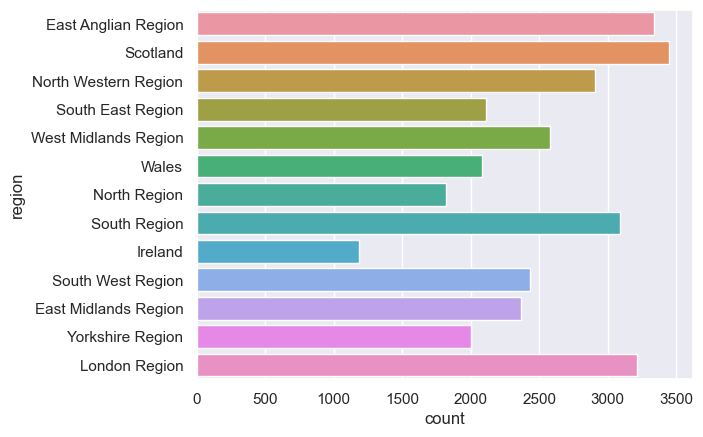

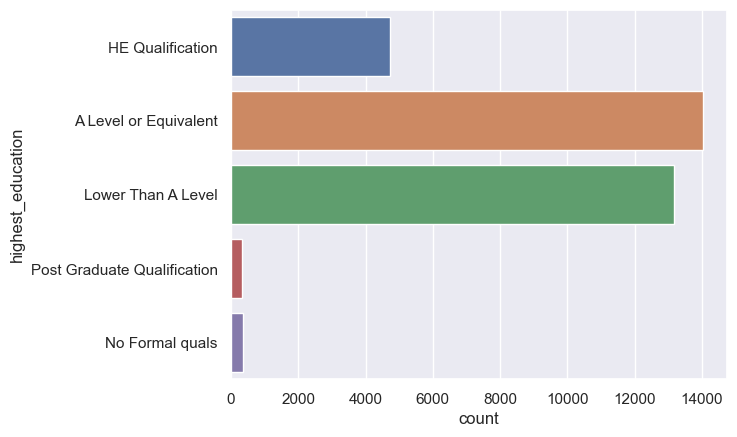

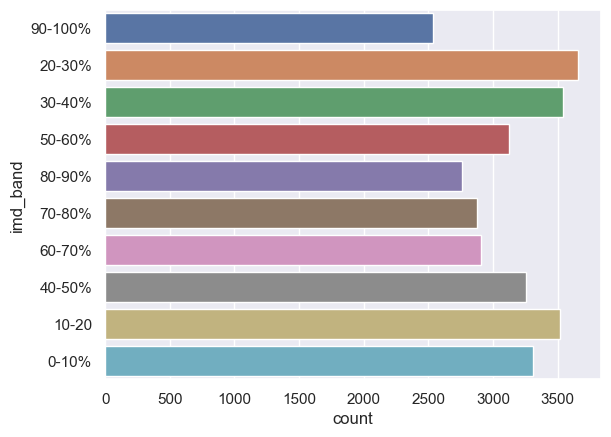

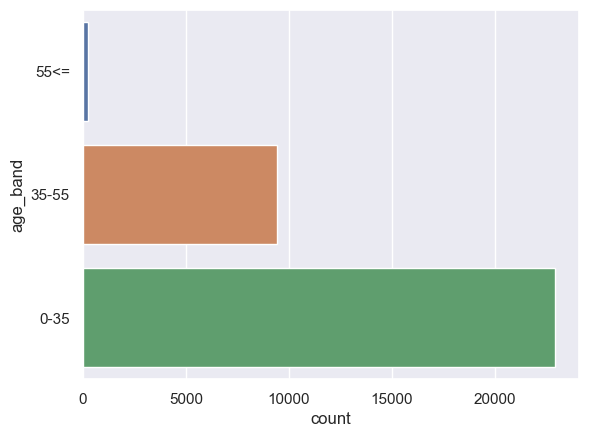

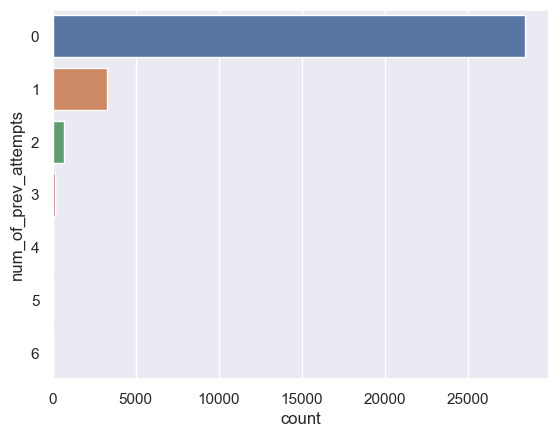

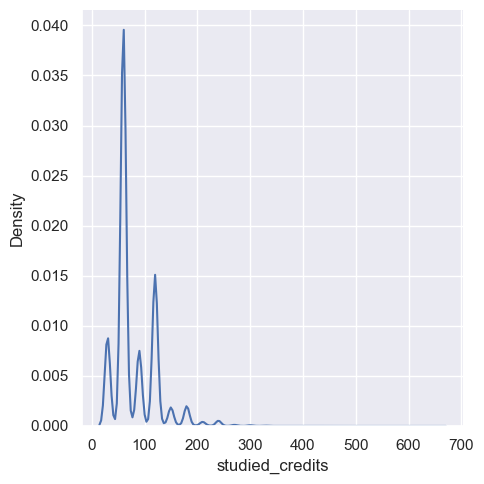

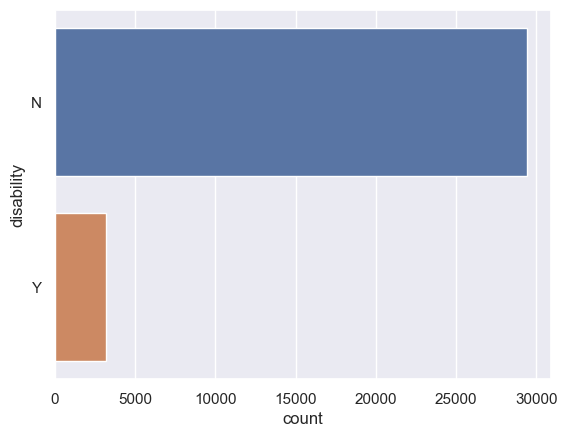

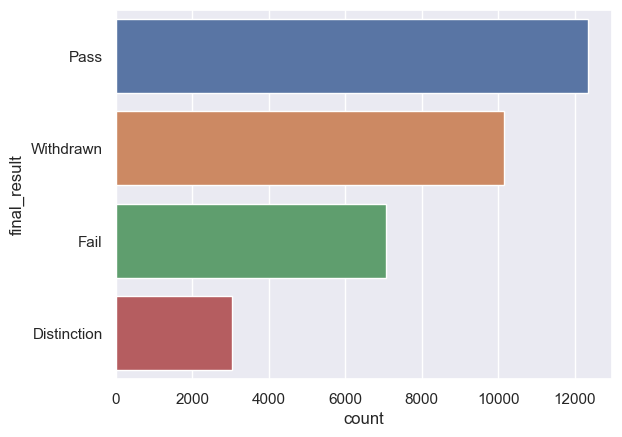

In [8]:
sns.set_theme(style="darkgrid")
for i, column in enumerate(df.columns):
    if i>2 and i != 9:
        sns.countplot(y = column, data = df)
        plt.show()
    elif i == 9: 
        sns.displot(x = column, data = df, kind="kde")
        plt.show()

Certaines caractéristiques telles que les crédits étudiés, le nombre de tentatives précédentes, la tranche d'âge et le niveau d'éducation le plus élevé contiennent des observations extrêmes.

## studentRegistration.csv

In [9]:
df = data_dicts['studentRegistration']
df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


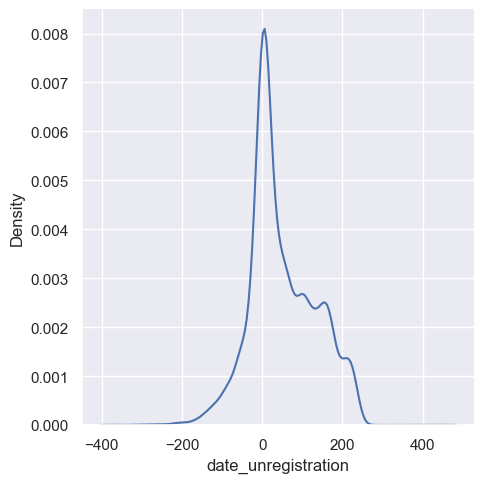

In [10]:
sns.displot(x = 'date_unregistration', data = df, kind="kde")
plt.show()

Le graphique montre qu'un grand nombre d'étudiants ont abandonné le cours avant son début. Nous supprimerons ces étudiants de notre ensemble de données ultérieurement, puisque nous ne disposons pas de données sur leurs performances académiques.

## studentAssessment.csv

In [11]:
df = data_dicts['studentAssessment']
df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [12]:
print("Le nombres de valeur manquante par colonne  ")
df.isnull().sum()

Le nombres de valeur manquante par colonne  


id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Selon la documentation des données, le score va de 0 à 100. Un score inférieur à 40 est interprété comme un échec. Si l'étudiant ne soumet pas l'évaluation, aucun résultat n'est enregistré. La plupart des scores manquants sont ceux des examens finaux, ce qui n'a pas d'impact sur notre analyse, puisque nous nous intéressons uniquement aux performances des étudiants au début du semestre.

## <p style="background-color:#709699;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">Préparation des données pour l'analyse</p>


In [13]:
def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

Nous voulons prédire le résultat final d'un étudiant sur la base de ses premières performances. Par performance, nous entendons deux choses : la performance académique, mesurée par les notes des étudiants, et l'engagement académique, mesuré par le nombre de fois où les étudiants cliquent sur le contenu du cours. Les trois variables ci-dessous contrôlent le nombre de jours dans un semestre que nous voulons inclure dans notre analyse.

In [14]:
score_deadline = 90
click_deadline = 90
withdraw_deadline = 90

Ci-dessous, nous avons une fonction qui crée un ensemble de données contenant la note moyenne des devoirs de chaque étudiant dans les premiers jours d'échéance de la note. Une autre fonction qui crée un ensemble de données contenant le nombre moyen de clics de chaque étudiant pour chaque catégorie de ressource dans les premiers jours de la date limite de clic. Puis une fonction pour fusionner les deux ensembles de données ensemble, ainsi que pour retirer les étudiants qui ont abandonné avant la date limite d'abandon. Puisque notre analyse ne concerne que la réussite ou l'échec, nous fusionnons les résultats finaux de la distinction avec la réussite et les abandons avec l'échec. L'idée est qu'après un certain temps, les seules personnes qui se retirent sont celles qui sont préoccupées par leurs performances et qui sont moins susceptibles de se retirer pour des raisons non académiques.

In [15]:
# score data

def create_score_df(score_deadline):

    df1 = data_dicts['assessments']
    df2 = data_dicts['studentAssessment']

    score_df = inner_merge(df1,
                           df2,
                           df2.columns,
                           ['id_assessment'],
                          )

    score_df = score_df[score_df['date'] < score_deadline]

    score_df = score_df[score_df['assessment_type'] != 'Exam']

    score_df = score_df.dropna(subset = ['score']) 

    score_df.isnull().sum()

    score_df['assessment_type'].value_counts()

    score_df = score_df.groupby(['code_module', 'code_presentation', 'id_student']).mean().reset_index()
    score_df = score_df.rename(columns = {'score': f'mean_score_day{score_deadline}'})
    score_df = score_df.drop(['date', 'weight', 
                              'date_submitted', 'is_banked',
                              'id_assessment'],
                             axis = 1)
    return score_df


In [16]:
# click data

def create_click_df(click_deadline):

    clicks = data_dicts['studentVle']

    clicks = inner_merge(clicks,
                         data_dicts['vle'],
                         ['id_site','code_module','code_presentation','activity_type'],
                         ['id_site','code_module','code_presentation'],
                        )

    clicks = clicks.drop('id_site', axis = 1)

    def clicks_xx(clicks,xx):
        temp = clicks[clicks['date'] <= xx]
        temp = temp.drop('date', axis = 1)
        temp = temp.groupby(['code_module','code_presentation','id_student','activity_type']).mean()
        temp = temp.rename(columns = {'sum_click': f'sum_click{xx} mean'})
        temp = temp.reset_index() # this fills out the missing columns for merging later 
        return temp

    click_data = pd.pivot_table(data = clicks_xx(clicks,click_deadline), 
                                index = ['code_module','code_presentation','id_student'],
                                columns = 'activity_type', 
                                values = [f'sum_click{click_deadline} mean'],
                                fill_value = 0,
                               ).reset_index()

    # get rid of multi index
    click_data = pd.concat([click_data['code_module'],
                            click_data['code_presentation'],
                            click_data['id_student'], 
                            click_data[f'sum_click{click_deadline} mean']], axis=1)
    return click_data

In [17]:
# merge score_df and click_df
def create_final_df(withdraw_deadline, score_df, click_df):

    final_df = inner_merge(click_df, # merge with StudentInfo
                           data_dicts['studentInfo'],
                           data_dicts['studentInfo'].columns,
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df.replace('Distinction','Pass') # merge Pass and Distinction

    final_df = inner_merge(final_df, 
                           data_dicts['studentRegistration'],
                           ['code_module', 'code_presentation', 'id_student', 'date_unregistration'],
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df[(final_df['final_result'] != 'Withdrawn') | # remove people who withdrew before withdraw_deadline
                       (final_df['date_unregistration'] > withdraw_deadline)]

    final_df = final_df.reset_index()

    final_df = final_df.drop(['date_unregistration','index'],axis = 1)

    final_df = inner_merge(final_df,
                           score_df,
                           score_df.columns,
                           ['code_module', 'code_presentation', 'id_student'])
    
    final_df = final_df.replace('Withdrawn','Fail') # merge Withdrawn to Fail

    return final_df

In [18]:
score_df = create_score_df(score_deadline)
click_df = create_click_df(click_deadline)
final_df = create_final_df(withdraw_deadline, score_df, click_df)

In [19]:
final_df

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score_day90
0,AAA,2013J,11391,0.0,0.0,0.0,3.514286,0.0,3.478261,0.0,...,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,81.5
1,AAA,2013J,28400,0.0,0.0,0.0,2.988889,0.0,5.194444,0.0,...,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,69.0
2,AAA,2013J,31604,0.0,0.0,0.0,2.955882,1.0,4.340000,0.0,...,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,71.5
3,AAA,2013J,32885,0.0,0.0,0.0,3.127660,2.0,3.600000,0.0,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,49.5
4,AAA,2013J,38053,7.0,0.0,0.0,3.457364,0.0,4.438596,0.0,...,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23738,GGG,2014J,2620947,0.0,0.0,0.0,3.500000,0.0,3.727273,0.0,...,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,Pass,80.0
23739,GGG,2014J,2645731,0.0,0.0,0.0,0.000000,0.0,4.000000,0.0,...,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Pass,80.0
23740,GGG,2014J,2648187,0.0,0.0,0.0,0.000000,1.0,2.750000,0.0,...,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,65.0
23741,GGG,2014J,2679821,0.0,0.0,0.0,8.214286,0.0,5.454545,0.0,...,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Fail,83.0


In [20]:
final_df['final_result'].value_counts()

Pass    15307
Fail     8436
Name: final_result, dtype: int64

Enfin, nous apportons quelques retouches au cadre de données avant de l'intégrer à notre modèle. Tout d'abord, nous voulons encoder toutes les variables catégorielles. Ici, nous utilisons l'encodage des étiquettes

In [21]:
def create_Xy(final_df):

    X = final_df.drop(['final_result','id_student','imd_band'],axis = 1)
    column_names = X.columns
    y = final_df['final_result']

    le = LabelEncoder()
    encode_dict = {}
    Xcat_features = ['code_module', 'code_presentation',
                    'gender', 'region',
                    'highest_education',  
                    'age_band','disability',
                   ]

    for cat_feature in Xcat_features: 
        X[cat_feature] = le.fit_transform(X[cat_feature])
        encode_dict[cat_feature] = le.classes_

    y = le.fit_transform(y)
    encode_dict['final_result'] = le.classes_

    X = X.to_numpy()
    
    return X,y,column_names,encode_dict


In [22]:
X,y,column_names,encode_dict = create_Xy(final_df)

In [23]:
# X
# y

Nous voulons également gérer la colinéarité potentielle des données. 

In [24]:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X = X[:, selected_features]
column_names = column_names[selected_features]

In [25]:
# column_names

## <p style="background-color:#709699;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">Le model</p>


## Régression logistique
Qu'est-ce que la régression logistique
La technique de modélisation statistique de régression logistique est utilisée lorsque nous avons une variable de résultat binaire. Par exemple : compte tenu des paramètres, l'élève réussira-t-il ou échouera-t-il ? Va-t-il pleuvoir ou pas ? etc.

Ainsi, bien que nous puissions avoir des variables indépendantes continues ou catégorielles, nous pouvons utiliser la technique de modélisation par régression logistique pour prédire le résultat lorsque la variable de résultat est binaire.

<center>
    <img src="img1.png">
</center>

## Le lien vers scikit-learn   <a href="https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression">Formulation mathématique</a>

In [26]:
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 , random_state = 42)

In [27]:
clf = LogisticRegression(penalty='l2')

In [28]:
model = clf.fit(x_train,y_train)

C:\Users\Abdoulaye MAIGA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
model.score(x_test,y_test)

0.7132027795325332

In [30]:
pred = clf.predict(x_test)

In [31]:
pred

array([1, 0, 0, ..., 1, 1, 1])

In [32]:
confusion_matrix(y_test,pred)

array([[ 620, 1085],
       [ 277, 2767]], dtype=int64)

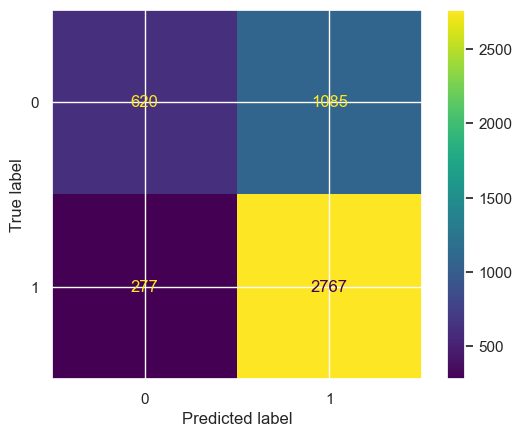

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test,pred) 
plt.show()

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold, KFold

In [35]:
param_grid = {'n_neighbors':np.arange(1,30),'metric':['minkowski','euclidean','manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid, cv = 5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [36]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 28}

In [37]:
knn = KNeighborsClassifier(n_neighbors = 28)

In [38]:
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=28)

In [39]:
knn.score(x_test,y_test)

0.7283638660770688

In [40]:
knn_pred = clf.predict(x_test)

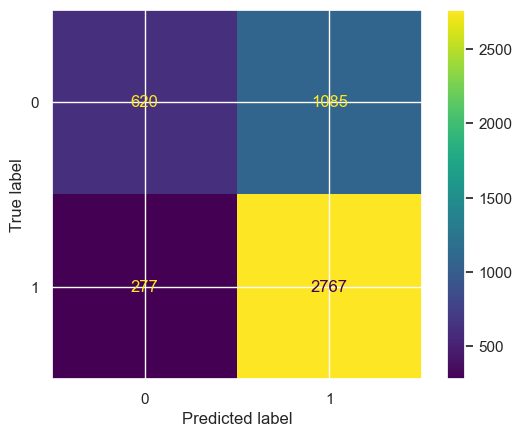

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test,knn_pred) 
plt.show()

Ici j’ai utilisé deux models à savoir : 
* La regression logistique (LogisticRegression)
* Le k  Voisins les plus proches (k Nearest Neighbors)

Les deux méthode m’ont données presque le meme resultat